In [1]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
from napari.utils import nbscreenshot
import os

from skimage.registration import phase_cross_correlation
from skimage.transform import SimilarityTransform
import cv2 as cv
from skimage import io
from PyQt5 import QtCore
import cupy as cp 

import imagej
%gui qt 
%matplotlib inline


In [2]:
# main_folder = r'E:\Ed\PSFCheck\20220318_Grid\20220318_M25_1'
main_folder = r'E:\Ed\PSF_defocus\20220311_M25_tamron_m25v2mfg2_3rows\20220311_M25_PSF4'
# main_folder = r'E:\Ed\PSF_defocus\20220315_M25_MFGlowindex\20220315_M25_PSF1'
# main_folder = r'E:\Ed\Data\test_flies\20220322_M25_larvae_05'

# folder = r'E:\Ed\PSF\20220124_M25_allcameras\CAM_Z2'
# file_extension = folder + '/' + '*.raw'
folder_names = sorted(glob(main_folder+ '/CAM*/'), key=alphanumeric_key)
offsets_file = os.path.join(main_folder,"offsets.csv")

# file_names = sorted(glob(file_extension),key=alphanumeric_key)

In [3]:
# Load offsets from desired folder 
main_folder = r'E:\Ed\PSF_defocus\20220318_M25_tamronall24cams_mfgno2\20220318_M25_PSF2'
offsets_file_load = os.path.join(main_folder,"offsets.csv")
with open(offsets_file_load) as file_name:
    offsets = np.loadtxt(file_name, delimiter=",")

In [4]:
# Read RAW files and return Dask Array
def imread_raw(raw_file, width=960, height=600, px_size='uint16'):
    raw_img = np.fromfile(raw_file, dtype= px_size)
    raw_reshape =np.reshape(raw_img,(1,height,width))
    return da.from_array(raw_reshape)

# # Read RAW files and return Dask Array
# def imread_raw(raw_file, width=960, height=600, px_size='uint8'):
#     raw_img = np.fromfile(raw_file, dtype= px_size)
#     raw_reshape =np.reshape(raw_img,(1,height,width))
#     return da.from_array(raw_reshape)

def dask_raw_ds(folder_name,px_depth):
    file_extension = folder_name + '/' + '*.raw'
    file_names = sorted(glob(file_extension),key=alphanumeric_key)
    raw_ds = [ imread_raw(fn,960,600,px_size= px_depth) for fn in file_names]
    # dask_raw_ds = da.stack(raw_ds,axis=1)
    return raw_ds

In [5]:
px_depth = 'uint16'
# px_depth = 'uint8'
height = 600
width =960

raw_M25_volume = [dask_raw_ds(fd,px_depth) for fd in folder_names]
stack = da.concatenate(raw_M25_volume, axis=1)
# stack_max_projection= np.array([ da.max(stack[:,i,:,:],axis=0) for i in range(stack.shape[1])])


In [6]:
viewer=napari.Viewer()
viewer.add_image(stack)

<Image layer 'stack' at 0x21a2a7ff5b0>

In [7]:
def registration(img_stack,ref_index):
    t,c,h,w =img_stack.shape
    stack_max_projection= np.array([ da.max(img_stack[:,i,:,:],axis=0) for i in range(img_stack.shape[1])])
    offset = np.array([phase_cross_correlation(stack_max_projection[ref_index], stack_max_projection[i]) for i in range(stack_max_projection.shape[0])],dtype=object)
    offset = offset[0:c,0]
    offset_coords = np.stack(offset[0:,],axis=0)
    return offset_coords

def align_projections(img_stack,offsets):
    stack_max_projection= np.array([ da.max(img_stack[:,i,:,:],axis=0) for i in range(img_stack.shape[1])])
    shifted= np.zeros_like(stack_max_projection)
    for i in range(img_stack.shape[1]):
        x_offset,y_offset = offsets[i]
        M = np.float32([
        [1, 0, y_offset],
        [0, 1, x_offset]
        ])
        stack_max_projection= np.float32(stack_max_projection)
        # print(M)
        shifted[i] = cv.warpAffine(stack_max_projection[i],M,(stack_max_projection[i].shape[1],stack_max_projection[i].shape[0]))
    return shifted

def align_stack(img_stack,offsets):
    shifted= np.zeros_like(img_stack)
    print(img_stack.shape)
    width = img_stack.shape[3] 
    height = img_stack.shape[2]
    img_stack= np.float32(img_stack)
    for i in range(img_stack.shape[1] ):
        x_offset,y_offset = offsets[i,0]
        M = np.float32([
        [1, 0, y_offset],
        [0, 1, x_offset]
        ])
        
        for j in range(img_stack.shape[0]):
            shifted[j,i] = cv.warpAffine(img_stack[j,i],M,(width,height))
    
    return shifted


def np_align_stack(image_stack,offsets):
    from scipy.ndimage import shift 
    t,c,h,w = image_stack.shape
    
    shift_stack = np.zeros_like(image_stack)
    columns = np.zeros((offsets.shape[0],1))
    shift_stack_coord = np.hstack((columns,offsets))
    for i in range(c):
        shift_stack[:,i,:,:] = shift(image_stack[:,i,:,:],shift_stack_coord[i])
    return shift_stack

## Problem with this functino is that it doesnt de-allocate the memory from GPU so it will crash
# def cp_align_stack(np_image_stack,offsets):
#     import cupy as cp
#     from cupyx.scipy.ndimage import shift 
#     image_stack = cp.array(np_image_stack)
#     t,c,h,w = image_stack.shape
#     shift_stack = cp.zeros_like(image_stack)
#     columns = cp.zeros((offsets.shape[0],1))
#     shift_stack_coord = cp.hstack((columns,offsets))
#     for i in range(c):
#         shift_stack[:,i,:,:] = shift(image_stack[:,i,:,:],shift_stack_coord[i])
#     shift_stack = shift_stack.get()
#     mempool = cp.get_default_memory_pool()
#     pinned_mempool = cp.get_default_pinned_memory_pool()
#     mempool.free_all_blocks()
#     pinned_mempool.free_all_blocks()
#     return shift_stack

def cp_align(np_image_stack, offsets):
    from cupyx.scipy.ndimage import shift
    t,c,h,w = np_image_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    shift_stack_output = []
    columns = cp.zeros((offsets.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offsets))
    
    for i in range(c):
        cam_stack = cp.array(np_image_stack[:,i,:,:])
        shift_stack_cam= shift(cam_stack,shift_stack_coord[i])
        shift_stack_output.append(cp.asnumpy(shift_stack_cam))
        # TODO: Check  this is proper way of transfering from GPU to CPU
        shift_stack_cam = None
        cam_stack = None
        # print("post")
    shift_stack_coord = None
    aligned_stack = np.array(shift_stack_output)
    return np.moveaxis(aligned_stack,0,1)
    # return shift_stack_output

def cuda_mem_info(device_id =0):
    with cp.cuda.Device(device_id):
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()

        print(mempool.used_bytes())              # 
        print(mempool.total_bytes())             #
        print(pinned_mempool.n_free_blocks())    #

def cuda_clear(device_id=0):
    with cp.cuda.Device(device_id):
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
        print(mempool.used_bytes())              # 
        print(mempool.total_bytes())             #
        print(pinned_mempool.n_free_blocks())    #

In [8]:
# viewer=napari.Viewer()
# viewer.add_image(stack)

In [9]:

def start_imagej():
    global ij
    ij = imagej.init(r'C:\Users\Callisto\Documents\edhirata\software\Fiji.app',headless=False)
    ij.ui().showUI()
    print(ij.getVersion())

QtCore.QTimer.singleShot(0, start_imagej)

In [10]:
# Align the files
aligned_volume_cp = cp_align(stack,offsets)
viewer.add_image(np.array(aligned_volume_cp))

2.3.0/1.53f


<Image layer 'Image' at 0x21bb2436790>

In [8]:
# def start_imagej():
#     global ij
#     ij = imagej.init(headless=False)
#     ij.ui().showUI()
#     print(ij.getVersion())

# QtCore.QTimer.singleShot(0, start_imagej)

In [11]:
ij_stack2  = ij.py.to_java(np.array(stack))
ij.ui().show('stack2',ij_stack2)

In [ ]:
#Get the Offsets and save in folder
offsets = registration(stack,11)
#Save the Offsets into the folder
np.savetxt(offsets_file, offsets, delimiter=',')

In [ ]:
# Align the files
aligned_volume_cp = cp_align(stack,offsets)
viewer.add_image(np.array(aligned_volume_cp))
ij_stack2  = ij.py.to_java(np.array(aligned_volume_cp,dtype='uint16'))
ij.ui().show('aligned_stack', ij_stack2)

In [ ]:
aligned_volume_cp.shape
cuda_mem_info()
cuda_clear()

In [11]:
ij_stack3  = ij.py.to_java(np.array(stack,dtype='uint16'))
ij.ui().show('aligned_stack2', ij_stack3)

## Testing Grounds


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.style.use('dark_background')


In [ ]:

test_dir = r'C:\Users\Callisto\Documents\edhirata\tutorials\M25_napari\notebooks\test_data'
test_crop = os.path.join(test_dir,'dustball2_crop.jpeg')
main_img = os.path.join(test_dir,'dustball2.jpeg')


In [ ]:
#Template matching needs uint8 or float32 files
template = cv.imread(test_crop,0).astype(np.float32)
img = cv.imread(main_img,0).astype(np.float32)

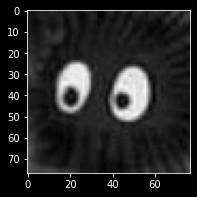

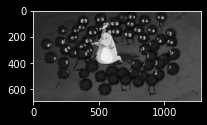

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(template,cmap='gray')
plt.figure(figsize=(3,3))
plt.imshow(img,cmap='gray')


## Taking Opencv tempalte matching example

In [ ]:
w,h = template.shape
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']


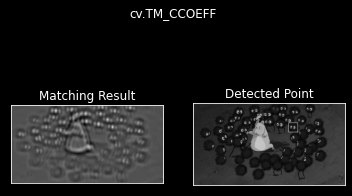

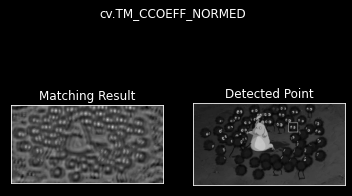

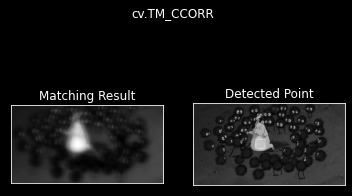

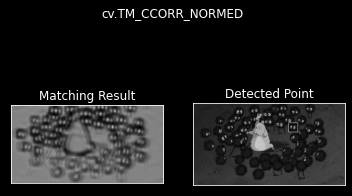

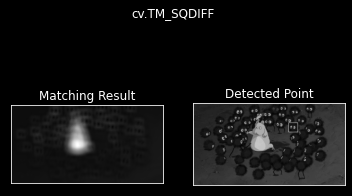

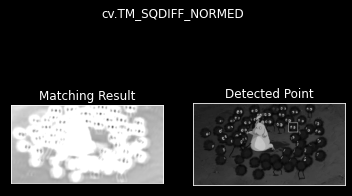

In [ ]:
for meth in methods:
    img2 = img.copy()
    method = eval(meth) # This method parses expression and runs ()
    
    # Apply template Matching
    # Slide through image and compare template patches.
    # Comparison of best matches is foudn as global minn in SQDIFF or max in CCORR or CCOEF.
    res = cv.matchTemplate(img2,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img2,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [ ]:
import napari
viewer=napari.Viewer()

In [ ]:
viewer.add_image(img)

<Image layer 'img' at 0x23918875c70>

In [ ]:
crop_template = img[]
viewer.add_image(crop_template)
# layer.data = crop_template

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
crop_region =viewer.layers['Shapes'].data[0]
cropped_img = crop(img,crop_region)
viewer.add_image(cropped_img)


<Image layer 'cropped_img' at 0x2391c06fc40>

In [ ]:
## https://forum.image.sc/t/mask-and-crop-with-napari/54008/2
def create_box(data):
    """Create integer box

    Parameters
    ----------
    data : (N, 2) array
        Points around which the box is created.

    Returns
    -------
    box : (2, 2) array
        Integrer extrema of the box.
    """
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    tl = np.array([min_val[0], min_val[1]])
    br = np.array([max_val[0], max_val[1]])
    box = np.round(np.array([tl, br])).astype(int)
    return box

def crop(image, rectangle):
    """Create integer box

    Parameters
    ----------
    image : (N, M) array
        2D image.
    rectangle : (4, 2) array or (2, 2) array
        Rectangle for cropping.

    Returns
    -------
    cropped_image : (U, V) array
        Cropped 2D image.
    """
    min_val, max_val = create_box(rectangle)
    return image[min_val[0]: max_val[0], min_val[1]: max_val[1]]

def align()